In [ ]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import scipy.io
import umap

import anndata
import scanpy as sc
from scvedge.vedge_model import VEDGE
import scvi
from sklearn.metrics import silhouette_score
from sklearn.neighbors import kneighbors_graph
#import alluvial

/home/Disk14T/xly/anaconda3/envs/xly/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/home/Disk14T/xly/anaconda3/envs/xly/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/home/Disk14T/xly/anaconda3/envs/xly/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/home/Disk14T/xly/anaconda3/envs/xly/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/home/Disk14T/xly/anaconda3/envs/xly/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarn

In [2]:
adata = anndata.read_h5ad("../Data/mixed_source_adata.h5ad.gz")

In [3]:
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"
os.environ["BLIS_NUM_THREADS"] = "1"
torch.set_num_threads(1)

In [ ]:
#TRAINING

VEDGE.setup_anndata(adata, batch_key='source', categorical_covariate_keys=['rep', 'tech'])
torch.set_float32_matmul_precision('high')
mvi = VEDGE(adata, 
                          (adata.var.modality=='Gene Expression').sum(), 
                          (adata.var.modality=='Peaks').sum(),
                          fully_paired=False
            )
mvi.train(batch_size = 32,
             early_stopping = True,
             early_stopping_patience = 50,
             adversarial_mixing=True)
mvi.save("../model_trained/mix_source_vedge")

In [4]:
adata = anndata.read_h5ad("../Data/mixed_source_adata.h5ad.gz")
VEDGE.setup_anndata(adata, batch_key='source', categorical_covariate_keys=['rep', 'tech'])
mvi = VEDGE.load("../model_trained/mix_source_vedge", adata)
adata.obsm["X_vedge"] = mvi.get_latent_representation()
sc.pp.neighbors(adata, use_rep="X_vedge")
sc.tl.umap(adata, min_dist=0.2)

INFO     File ../model_trained/mix_source_vedge/model.pt already downloaded                                        


/home/Disk14T/xly/anaconda3/envs/xly/lib/python3.12/site-packages/torch/nn/init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


In [ ]:
# adata.write("../Data/adata.h5ad.gz", compression='gzip')

In [ ]:
# adata = anndata.read("adata.h5ad.gz")

In [ ]:
adata

# cleanup annotations

In [5]:
adata.obs["final_ct"] = adata.obs.celltype.copy()
## relabel and collapse Ding annotations to existing Satpathy annotations if possible
adata.obs.final_ct = (adata.obs.final_ct
    .replace("CD14+ monocyte", "Monocyte")
    .replace("CD16+ monocyte", "Monocyte")
    .replace("Natural killer cell", "NK Cell")
    .replace("Cytotoxic T cell", "CD8+ T Cell")
    .replace("CD4+ T cell", "CD4+ T Cell")
    .replace("Plasmacytoid dendritic cell", "pDC")
    .replace("Dendritic cell", "Dendritic Cell")
    .replace("B cell", "B Cell")
)
## relabel and collapse Satpathy annotations to match existing Ding annotations if possible
adata.obs.final_ct = (adata.obs.final_ct
    .replace("Monocytes", "Monocyte")
    .replace("NK_Cells", "NK Cell")
    .replace("Naive_CD8_T_Cells", "CD8+ T Cell")
    .replace("Memory_CD8_T_Cells", "CD8+ T Cell")
    .replace("Naive_CD4_T_Cells", "CD4+ T Cell")
    .replace("Memory_CD4_T_Cells", "CD4+ T Cell")
    .replace("CD4_HelperT", "CD4+ T Cell")
    .replace("BM_pDC", "pDC")
    .replace("Dendritic_Cells", "Dendritic Cell")
    .replace("B_Cells", "B Cell")
    .replace("Regulatory_T_Cells", "TRegs")
)
adata.obs.final_ct = adata.obs.final_ct.replace("Unassigned", "Unknown")

/tmp/ipykernel_2563402/3083315937.py:4: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  .replace("CD14+ monocyte", "Monocyte")
/tmp/ipykernel_2563402/3083315937.py:5: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  .replace("CD16+ monocyte", "Monocyte")
/tmp/ipykernel_2563402/3083315937.py:6: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  .replace("Natural k

In [6]:
# only keep shared, cell type specific labels
adata_labelled = adata[adata.obs.final_ct.isin([
     'B Cell',
#      'Bone_Marrow',
     'CD4+ T Cell',
     'CD8+ T Cell',
     'Dendritic Cell',
#      'Megakaryocyte',
     'Monocyte',
     'NK Cell',
#      'PBMC',
#      'TRegs',
#      'Unknown',
     'pDC',
    ])].copy()

In [ ]:
nng = kneighbors_graph(adata_labelled.obsm["X_vedge"], n_neighbors=100).tocoo()

In [20]:
anndf = pd.DataFrame({
    'self_label': adata_labelled.obs.final_ct[nng.row].astype(str).values,
    'neigh_label': adata_labelled.obs.final_ct[nng.col].astype(str).values,
    'self_source': adata_labelled.obs.source[nng.row].astype(str).values,
    'neigh_source': adata_labelled.obs.source[nng.col].astype(str).values,
})
anndf.head()

/tmp/ipykernel_1797347/177105745.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'self_label': adata_labelled.obs.final_ct[nng.row].astype(str).values,
/tmp/ipykernel_1797347/177105745.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'neigh_label': adata_labelled.obs.final_ct[nng.col].astype(str).values,
/tmp/ipykernel_1797347/177105745.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'self_source': adata_labelled.obs.sour

,self_label,neigh_label,self_source,neigh_source
0,CD4+ T Cell,CD4+ T Cell,Satpathy,Satpathy
1,CD4+ T Cell,CD4+ T Cell,Satpathy,Satpathy
2,CD4+ T Cell,CD4+ T Cell,Satpathy,Satpathy
3,CD4+ T Cell,CD4+ T Cell,Satpathy,Satpathy
4,CD4+ T Cell,CD4+ T Cell,Satpathy,Satpathy


In [21]:
set(anndf.self_source)

{'Ding', 'Satpathy'}

In [22]:
anndf = anndf.loc[anndf.self_source != anndf.neigh_source]

In [23]:
wmat = pd.crosstab(anndf.self_label, anndf.neigh_label)
wmat = (wmat.T / wmat.sum(axis=1)).T
# wmat = wmat / wmat.sum(axis=0)
# wmat

In [24]:
order = [
    'B Cell',
    'CD4+ T Cell',
    'CD8+ T Cell',
    'NK Cell',
    'Monocyte',
    'Dendritic Cell',
    'pDC',
]
wmat = wmat.loc[order, order]

Text(50.72222222222221, 0.5, '')

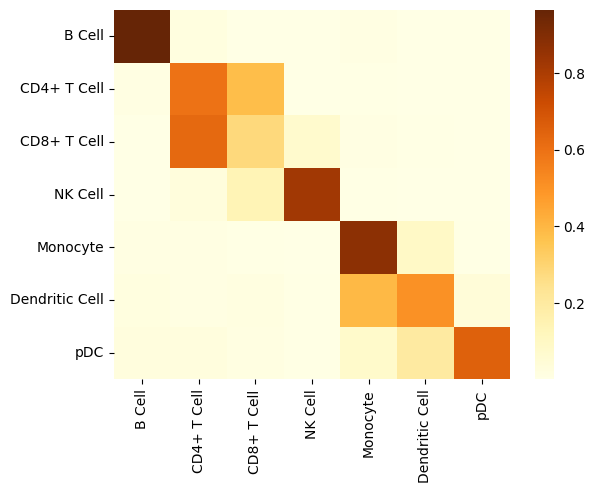

In [25]:
sns.heatmap(wmat, cmap="YlOrBr")
plt.xlabel("")
plt.ylabel("")
#plt.savefig(os.path.join(FIGPATH, "F3_annotHM.{}".format(FIGFORMAT)))

In [ ]:
import sklearn.cluster
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

# 1. 提取 MultiVI 低维嵌入
latent = adata_labelled.obsm["X_vedge"]

from sklearn.decomposition import PCA
latent = PCA(n_components=10).fit_transform(latent)

# 2. 设定聚类数（根据 ground truth 细胞类型数）
n_clusters = adata_labelled.obs["final_ct"].nunique()

# 3. 运行 K-means 聚类
kmeans = sklearn.cluster.KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
adata_labelled.obs["multiVI_clusters"] = kmeans.fit_predict(latent)

# 4. 计算 ARI 和 NMI
true_labels = adata_labelled.obs["final_ct"].values  # 真实细胞类型
pred_labels = adata_labelled.obs["multiVI_clusters"].values  # K-means 聚类标签

ari = adjusted_rand_score(true_labels, pred_labels)
nmi = normalized_mutual_info_score(true_labels, pred_labels)

print(f"Adjusted Rand Index (ARI): {ari:.4f}")
print(f"Normalized Mutual Information (NMI): {nmi:.4f}")

asw_cell_type=silhouette_score(latent, adata_labelled.obs.final_ct, metric='euclidean')
asw_cell_type

Adjusted Rand Index (ARI): 0.5053
Normalized Mutual Information (NMI): 0.6179


0.18439773

In [ ]:
# 重新跑 neighbors
sc.pp.neighbors(adata, use_rep="X_vedge", n_neighbors=100)

# 跑 iLISI
from scib.metrics import lisi_graph
import pandas as pd

ilisi, clisi = lisi_graph(
    adata=adata,
    batch_key="source",
    label_key="final_ct",
    use_rep = 'X_vedge',
    type_="embed",
    k0=100,
)

print("iLISI score:", round(ilisi, 4))
print("cLISI score:", round(clisi, 4))


iLISI score: 0.3232
cLISI score: 0.8873


# UMAPs

In [7]:
adata.obsm["umap_wbc"] = umap.UMAP(random_state=420).fit_transform(adata.obsm["X_vedge"])

/home/Disk14T/xly/anaconda3/envs/xly/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


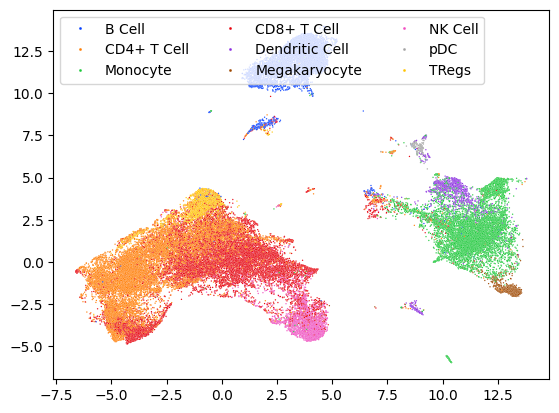

In [8]:
adata_plt = adata[np.random.choice(
        np.arange(adata.shape[0]), 
        adata.shape[0], 
        replace=False
    )].copy()
adata_plt = adata_plt[~adata_plt.obs.final_ct.isin(["Unknown", "PBMC", "Bone_Marrow"])].copy()
sns.scatterplot(
    x=adata_plt.obsm["umap_wbc"][:,0],
    y=adata_plt.obsm["umap_wbc"][:,1],
    hue=adata_plt.obs.final_ct,
    s=1,
    palette='bright',
)
plt.legend(
#     loc='lower left', 
    loc='upper left',
    ncol=3,
#     bbox_to_anchor=(1, 0.5)
     markerscale=2, 
)
#plt.savefig(os.path.join(FIGPATH, "F3_mixumap_ct.{}".format(FIGFORMAT)), bbox_inches='tight')

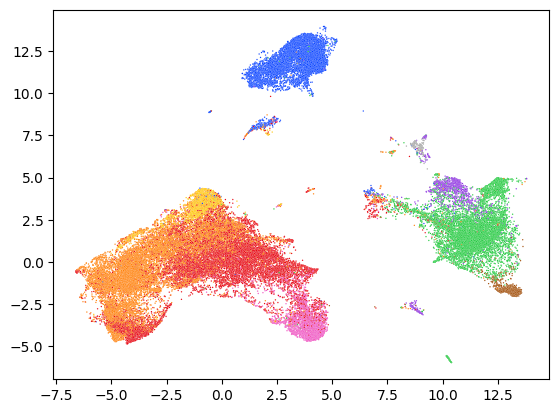

In [8]:

sns.scatterplot(
    x=adata_plt.obsm["umap_wbc"][:,0],
    y=adata_plt.obsm["umap_wbc"][:,1],
    hue=adata_plt.obs.final_ct,
    s=1,
    palette='bright',
)
plt.legend().remove()
#plt.savefig(os.path.join(FIGPATH, "F3_mixumap_ct.{}".format(FIGFORMAT)), bbox_inches='tight')

/tmp/ipykernel_1876316/3397652646.py:8: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  .replace('Satpathy', 'scATAC (Satpathy)')
/tmp/ipykernel_1876316/3397652646.py:9: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  .replace('Ding', 'scRNA (Ding)')
/tmp/ipykernel_1876316/3397652646.py:10: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  .replace('10x_arc', '

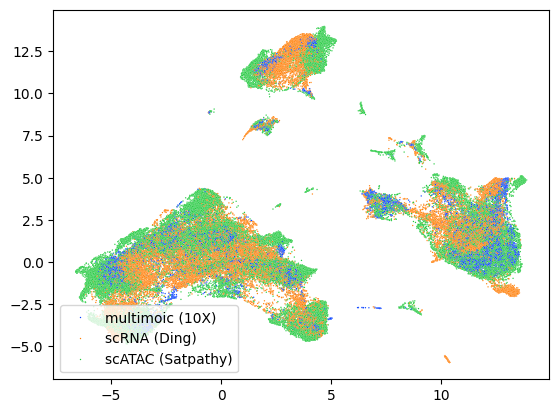

In [9]:
adata_plt = adata[np.random.choice(
        np.arange(adata.shape[0]), 
        adata.shape[0], 
        replace=False
    )].copy()
adata_plt.obs.source = (
    adata_plt.obs.source
    .replace('Satpathy', 'scATAC (Satpathy)')
    .replace('Ding', 'scRNA (Ding)')
    .replace('10x_arc', 'multimoic (10X)')
)
sns.scatterplot(
    x=adata_plt.obsm["umap_wbc"][:,0],
    y=adata_plt.obsm["umap_wbc"][:,1],
    hue=adata_plt.obs.source,
    s=1,
    palette='bright',
)
plt.legend(title='', loc='lower left')#, bbox_to_anchor=(1, 0.5))
#plt.savefig(os.path.join(FIGPATH, "F3_mixumap_source.{}".format(FIGFORMAT)), bbox_inches='tight')

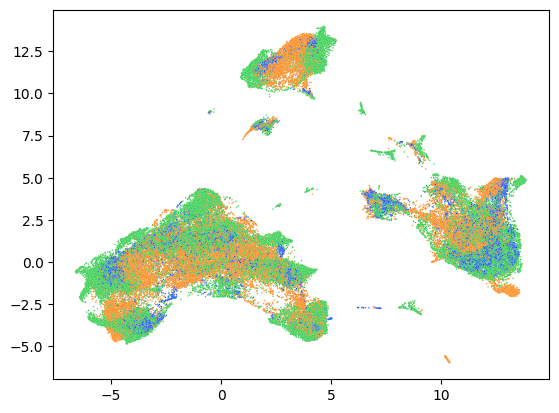

In [10]:

sns.scatterplot(
    x=adata_plt.obsm["umap_wbc"][:,0],
    y=adata_plt.obsm["umap_wbc"][:,1],
    hue=adata_plt.obs.source,
    s=1,
    palette='bright',
)
plt.legend().remove()#, bbox_to_anchor=(1, 0.5))
#plt.savefig(os.path.join(FIGPATH, "F3_mixumap_source.{}".format(FIGFORMAT)), bbox_inches='tight')

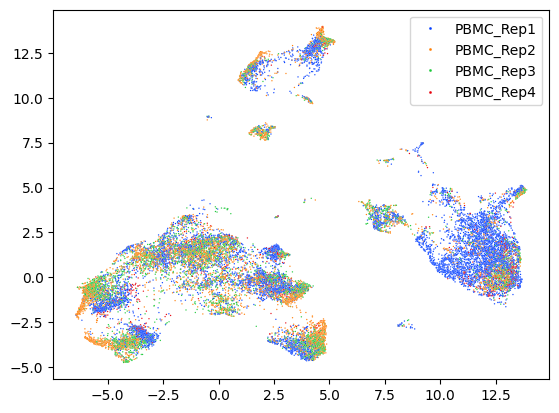

In [12]:
# plt.figure(figsize=(5,5))
adata_plt = adata[np.random.choice(
        np.arange(adata.shape[0]), 
        adata.shape[0], 
        replace=False
    )].copy()
adata_plt = adata_plt[adata_plt.obs.final_ct == "PBMC"]
sns.scatterplot(
    x=adata_plt.obsm["umap_wbc"][:,0],
    y=adata_plt.obsm["umap_wbc"][:,1],
    hue=adata_plt.obs.rep,
    s=1,
    palette='bright',
)
plt.legend(title=None,
           markerscale=2, )#, loc='center left') #, bbox_to_anchor=(1, 0.5),)
#plt.savefig(os.path.join(FIGPATH, "F3_mixumap_rep.{}".format(FIGFORMAT)), bbox_inches='tight')

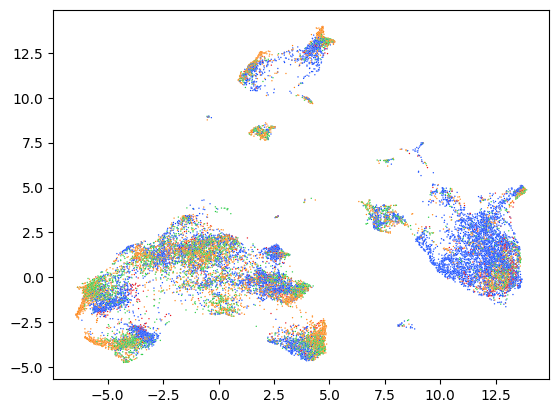

In [12]:
sns.scatterplot(
    x=adata_plt.obsm["umap_wbc"][:,0],
    y=adata_plt.obsm["umap_wbc"][:,1],
    hue=adata_plt.obs.rep,
    s=1,
    palette='bright',
)
plt.legend().remove()#, loc='center left') #, bbox_to_anchor=(1, 0.5),)

/tmp/ipykernel_4044110/2769665087.py:8: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  .replace('10x Chromium (v2) A', '10x Chromium (v2)')
/tmp/ipykernel_4044110/2769665087.py:9: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  .replace('10x Chromium (v2) B', '10x Chromium (v2)')


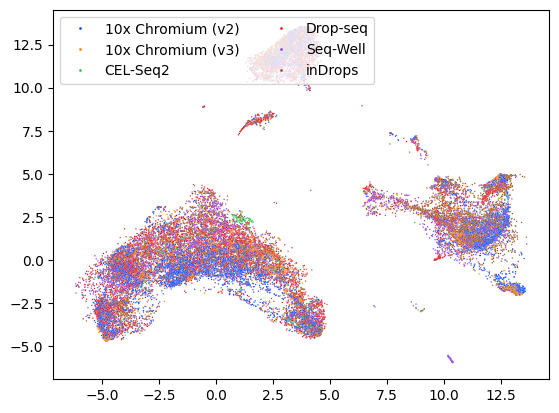

In [13]:
adata_plt = adata[np.random.choice(
        np.arange(adata.shape[0]), 
        adata.shape[0], 
        replace=False
    )].copy()
adata_plt = adata_plt[adata_plt.obs.source == "Ding"].copy()
adata_plt.obs.tech = (adata_plt.obs.tech
                      .replace('10x Chromium (v2) A', '10x Chromium (v2)')
                      .replace('10x Chromium (v2) B', '10x Chromium (v2)')
                     )
sns.scatterplot(
    x=adata_plt.obsm["umap_wbc"][:,0],
    y=adata_plt.obsm["umap_wbc"][:,1],
    hue=adata_plt.obs.tech,
    s=1,
    palette='bright',
)
plt.legend(
    loc='upper left', 
#     bbox_to_anchor=(1, 0.5), 
    ncol=2,
    markerscale=2,
)
#plt.savefig(os.path.join(FIGPATH, "F3_mixumap_tech.{}".format(FIGFORMAT)), bbox_inches='tight')

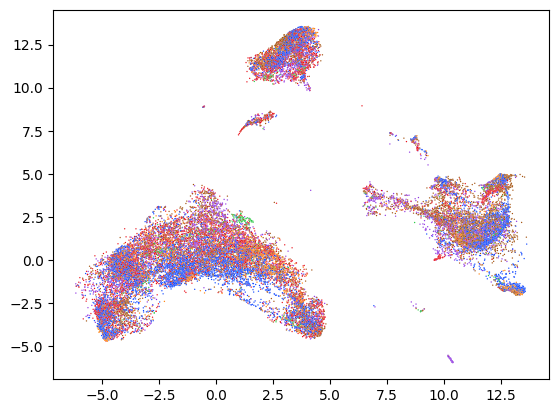

In [14]:
sns.scatterplot(
    x=adata_plt.obsm["umap_wbc"][:,0],
    y=adata_plt.obsm["umap_wbc"][:,1],
    hue=adata_plt.obs.tech,
    s=1,
    palette='bright',
)
plt.legend().remove()

In [31]:
def compute_batch_mixing(latent, batch_id, k):
    nng = kneighbors_graph(latent, n_neighbors=k).tocoo()
    batch_id = pd.Categorical(batch_id).codes
    self_id = batch_id[nng.row]
    ne_id = batch_id[nng.col]
    
    _, c = np.unique(batch_id, return_counts=True)
    theoretic_score = ((c / c.sum()) ** 2).sum()
    return (self_id == ne_id).mean() / theoretic_score

In [ ]:
latent = adata.obsm['X_vedge']
enrichment_rep=compute_batch_mixing(latent, adata.obs.rep, 100)
asw_rep=silhouette_score(latent, adata.obs.rep, metric='euclidean')
print(enrichment_rep)
print(asw_rep)

4.109541554974772
-0.29930183


In [33]:
enrichment_tech=compute_batch_mixing(latent, adata.obs.tech, 100)
asw_tech=silhouette_score(latent, adata.obs.tech, metric='euclidean')
print(enrichment_tech)
print(asw_tech)

1.873320081020813
-0.067740664


In [ ]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
import networkx as nx
from anndata import AnnData

def compute_graph_connectivity(adata: AnnData, embedding_key: str, label_key: str, k: int = 15) -> float:
    # Step 1: 获取嵌入和标签
    embedding = adata.obsm[embedding_key]
    labels = adata.obs[label_key]

    # Step 2: 创建邻接图（基于 kNN）
    knn = NearestNeighbors(n_neighbors=k+1).fit(embedding)
    distances, indices = knn.kneighbors(embedding)

    # 创建无向图（排除自身）
    G = nx.Graph()
    for i in range(len(embedding)):
        for j in indices[i][1:]:
            G.add_edge(i, j)

    # Step 3: 对每个细胞类型计算最大连通子图比例
    unique_labels = labels.unique()
    scores = []

    for label in unique_labels:
        idx = np.where(labels == label)[0]
        subgraph = G.subgraph(idx)
        if len(subgraph) == 0:
            scores.append(0.0)
            continue
        largest_cc = max(nx.connected_components(subgraph), key=len)
        scores.append(len(largest_cc) / len(idx))

    # Step 4: 平均所有细胞类型的连通性得分
    return np.mean(scores)

score = compute_graph_connectivity(
    adata=adata,
    embedding_key="X_vedge",
    label_key="final_ct",  # 真实细胞类型
    k=50
)
print("Graph Connectivity Score:", round(score, 4))


Graph Connectivity Score: 0.9923


## figures

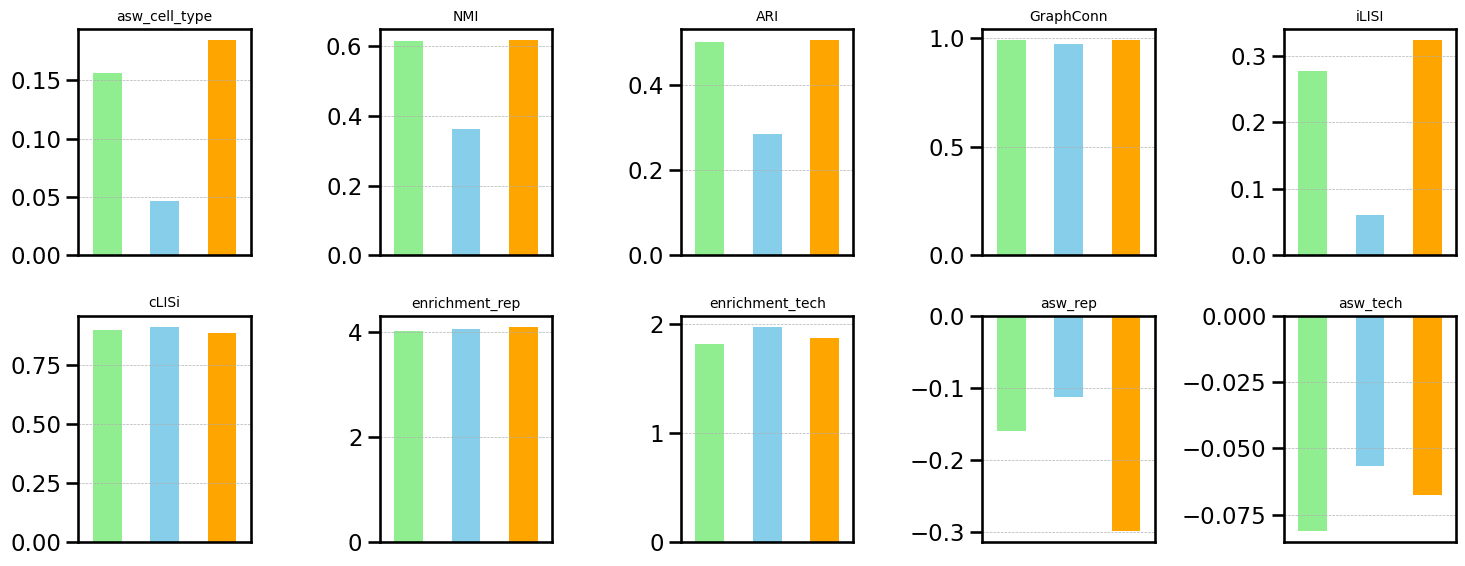

In [13]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd


data = pd.DataFrame({
    'asw_cell_type': [0.15592366, 0.04623826, 0.18439773],
    'NMI': [0.6141, 0.3630, 0.6179],
    'ARI': [0.5001, 0.2857, 0.5053],
    'GraphConn': [0.9916, 0.976, 0.9923],
    'iLISI': [0.2765,  0.0612, 0.3232],
    'cLISi': [0.8998, 0.9143, 0.8873],
    'enrichment_rep': [4.022068410453165, 4.054752261979088, 4.109541554974772],
    'enrichment_tech': [1.8218361405909111, 1.9803038849106966, 1.873320081020813],
    'asw_rep': [-0.15935078, -0.11243914, -0.29930183],
    'asw_tech': [-0.081228875, -0.056595992, -0.067740664],
}, index=['MultiVI', 'Cobolt', 'scVEDGE'])

# 图设置
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()

colors = ['lightgreen', 'skyblue', 'orange']

# 绘图
for i, metric in enumerate(data.columns):
    ax = axes[i]
    data[metric].plot(kind='bar', ax=ax, color=colors)
    ax.set_title(metric, fontsize=10)
    ax.set_xticks([])  # 去掉x轴标签
    ax.set_xticklabels([])  # 再保险：禁用标签
    ax.grid(axis='y', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()

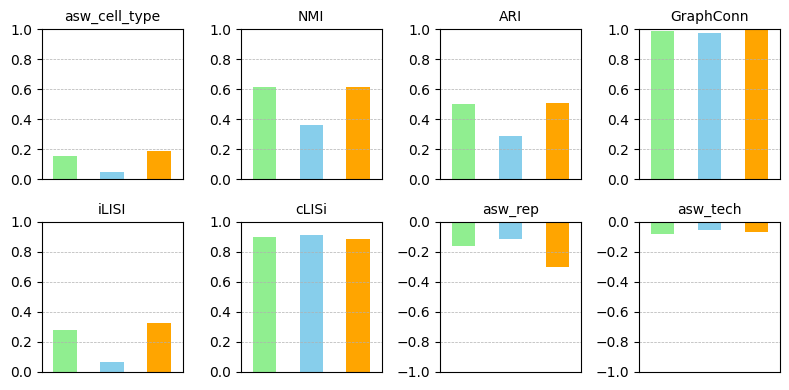

In [8]:
import matplotlib.pyplot as plt
import pandas as pd

data = pd.DataFrame({
    'asw_cell_type': [0.15592366, 0.04623826, 0.18439773],
    'NMI': [0.6141, 0.3630, 0.6179],
    'ARI': [0.5001, 0.2857, 0.5053],
    'GraphConn': [0.9916, 0.976, 0.9923],
    'iLISI': [0.2765,  0.0612, 0.3232],
    'cLISi': [0.8998, 0.9143, 0.8873],
    #'enrichment_rep': [4.022068410453165, 4.054752261979088, 4.109541554974772],
    #'enrichment_tech': [1.8218361405909111, 1.9803038849106966, 1.873320081020813],
    'asw_rep': [-0.15935078, -0.11243914, -0.29930183],
    'asw_tech': [-0.081228875, -0.056595992, -0.067740664],
}, index=['MultiVI', 'Cobolt', 'scVEDGE'])

fig, axes = plt.subplots(2, 4, figsize=(8, 4))
axes = axes.flatten()

colors = ['lightgreen', 'skyblue', 'orange']

# 需要保持原始范围的指标
skip_ylim = ['enrichment_rep', 'enrichment_tech']

for i, metric in enumerate(data.columns):
    ax = axes[i]
    data[metric].plot(kind='bar', ax=ax, color=colors)

    # 设置标题与X轴
    ax.set_title(metric, fontsize=10)
    ax.set_xticks([])
    ax.set_xticklabels([])
    ax.grid(axis='y', linestyle='--', linewidth=0.5)

    # 设置Y轴范围（除了 enrichment）
    if metric not in skip_ylim:
        if data[metric].min() < 0:
            ax.set_ylim(-1, 0)
        else:
            ax.set_ylim(0, 1)

plt.tight_layout()
plt.show()
